<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/CondyleClassification/blob/main/Lhri_Thy.MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy-stl
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 7.0 MB/s eta 0:00:00


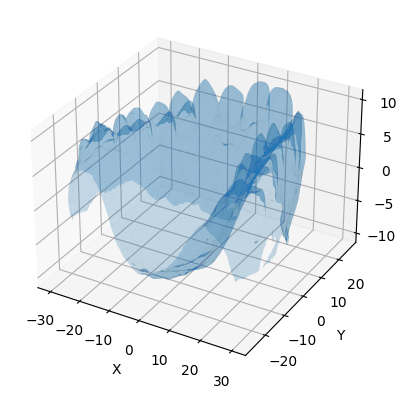

In [ ]:
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from stl import mesh
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Load STL file
mesh_file = '/content/drive/Shareddrives/3D/3Ddataset/target_smpl/6.stl'
my_mesh = mesh.Mesh.from_file(mesh_file)

# Extract vertices and faces
vertices = my_mesh.vectors.reshape(-1, 3)
faces = np.arange(vertices.shape[0]).reshape(-1, 3)

# Create a figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a Poly3DCollection from the faces
poly3d = [Poly3DCollection([vertices[face] for face in faces], alpha=0.25)]
ax.add_collection3d(poly3d[0])  # Pass the first element of the list

# Set plot limits and labels
ax.set_xlim([np.min(vertices[:, 0]), np.max(vertices[:, 0])])
ax.set_ylim([np.min(vertices[:, 1]), np.max(vertices[:, 1])])
ax.set_zlim([np.min(vertices[:, 2]), np.max(vertices[:, 2])])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
from torch.utils.data import Dataset
import torch
from stl import mesh
import os

class STLPairDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.input_dir = os.path.join(root_dir, 'input_smpl')
        self.output_dir = os.path.join(root_dir, 'target_smpl')
        self.file_list = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        input_file = os.path.join(self.input_dir, self.file_list[idx])
        output_file = os.path.join(self.output_dir, self.file_list[idx])

        input_mesh = mesh.Mesh.from_file(input_file)
        input_vertices = input_mesh.vectors.reshape(-1, 3)

        output_mesh = mesh.Mesh.from_file(output_file)
        output_vertices = output_mesh.vectors.reshape(-1, 3)

        input_vertices_tensor = torch.tensor(input_vertices, dtype=torch.float32)
        output_vertices_tensor = torch.tensor(output_vertices, dtype=torch.float32)

      #  train_ratio = 0.8
       # train_size = int(train_ratio * len(input_vertices_tensor))
        train_input = input_vertices_tensor
        train_output = output_vertices_tensor
       # val_input = input_vertices_tensor[train_size:]
       # val_output = output_vertices_tensor[train_size:]


        return train_input, train_output


In [ ]:
from numpy import savez_compressed

MyDataset = STLPairDataset('/content/drive/Shareddrives/3D/3Ddataset')
#print('Loaded: ', src_images.shape, tar_images.shape)
filename = 'occscan.npz'
savez_compressed(filename,MyDataset )
print('Saved dataset:', filename)
#print('Loaded: ', train_input.shape, train_output.shape)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:716: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val = np.asanyarray(val)
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


Saved dataset: occscan.npz


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, \
    UpSampling2D, Concatenate, LeakyReLU
from tensorflow.keras.models import Model

# Define the generator model
def generator_model():
    # Encoder blocks
    def encoder_block(inputs, units):
        x = Dense(units)(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    # Decoder blocks
    def decoder_block(inputs, skip_features, units):
        x = Dense(units)(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    # Input
    input_dim = 3  # Adjust num_channels to match your data
    inputs = Input(shape=(60,40,20))

    # Encoder
    enc1 = encoder_block(inputs, units=64)
    enc2 = encoder_block(enc1, units=128)
    enc3 = encoder_block(enc2, units=256)

    # Decoder
    dec1 = decoder_block(enc3, skip_features=enc2, units=128)
    dec2 = decoder_block(dec1, skip_features=enc1, units=64)
    outputs = Dense(3, activation="tanh")(dec2)

    model = Model(inputs, outputs, name="generator")
    return model

# Define the discriminator model
def discriminator_model():
    input_dim = 3  # Adjust num_channels to match your data
    inputs = Input(shape=(60,40,20))

    x = Dense(64)(inputs)
    x = LeakyReLU(0.2)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(1)(x)
    outputs = tf.keras.activations.sigmoid(x)

    model = Model(inputs, outputs, name="discriminator")
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from keras.optimizers import Adam

# Define the combined generator and discriminator model
class GANModel(nn.Module):
    def __init__(self, generator, discriminator):
        super(GANModel, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, input):
        # Make weights in the discriminator not trainable
        for param in self.discriminator.parameters():
            param.requires_grad = False

        # Define the source input
        in_src = input

        # Connect the source input to the generator input
        gen_out = self.generator(in_src)

        # Connect the source input and generator output to the discriminator input
        dis_out = self.discriminator(torch.cat((in_src, gen_out), dim=1))

        return dis_out, gen_out

# Create the combined GAN model
image_shape = (60,40,20)  # Adjust the image shape as needed
generator = generator_model()  # Instantiate your generator model
discriminator = discriminator_model()  # Instantiate your discriminator model

gan_model = GANModel(generator, discriminator)

# Define the optimizer
lr = 0.0002
beta1 = 0.5
optimizer = optim.Adam(gan_model.generator('/content/occscan.npz'), lr=lr, betas=(beta1, 0.999))




# Define the loss function and weights
criterion_dis = nn.BCELoss()  # Binary Cross-Entropy Loss
criterion_gen = nn.L1Loss()   # Mean Absolute Error Loss
lambda_weight = 100  # Adjust the weight as needed

# Use the optimizer and loss function to compile the model
def compile_gan_model(gan_model, optimizer, criterion_dis, criterion_gen, lambda_weight):
    gan_model.optimizer = optimizer
    gan_model.criterion_dis = criterion_dis
    gan_model.criterion_gen = criterion_gen
    gan_model.lambda_weight = lambda_weight

compile_gan_model(gan_model, optimizer, criterion_dis, criterion_gen, lambda_weight)


TypeError: ignored

In [ ]:
from tensorflow.keras.optimizers import Adam

image_shape = (60,40,20)  # Adjust the image shape as needed
generator = generator_model()  # Instantiate your generator model
discriminator = discriminator_model()  # Instantiate your discriminator model

gan_model = GANModel(generator, discriminator)

# Define the optimizer
lr = 0.0002
beta1 = 0.5
opt = Adam(lr=lr, betas=(beta1, 0.999))
model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])


# Define the loss function and weights
criterion_dis = nn.BCELoss()  # Binary Cross-Entropy Loss
criterion_gen = nn.L1Loss()   # Mean Absolute Error Loss
lambda_weight = 100  # Adjust the weight as needed



TypeError: ignored

In [ ]:
# Use the optimizer and loss function to compile the model
def compile_gan_model(gan_model, optimizer, criterion_dis, criterion_gen, lambda_weight):
    gan_model.optimizer = optimizer
    gan_model.criterion_dis = criterion_dis
    gan_model.criterion_gen = criterion_gen
    gan_model.lambda_weight = lambda_weight

compile_gan_model(gan_model, optimizer, criterion_dis, criterion_gen, lambda_weight)

In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset

def load_real_samples(filename):
    # Load compressed arrays (assuming the file is in NumPy format)
    data = np.load(filename)

    # Unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']

    # Create PyTorch tensors from the NumPy arrays
    X1_tensor = torch.tensor(X1, dtype=torch.float32)
    X2_tensor = torch.tensor(X2, dtype=torch.float32)

    # Normalize the data if necessary
    # You can apply custom preprocessing steps for 3D objects here

    # Create PyTorch datasets
    dataset = TensorDataset(X1_tensor, X2_tensor)

    return dataset


In [ ]:
import torch
import torch.nn.functional as F
import torch.utils.data as data

def generate_real_samples(dataset, n_samples, patch_shape):
    # Unpack the dataset
    trainA, trainB = dataset

    # Randomly choose indices for the selected images
    ix = torch.randint(0, trainA.shape[0], (n_samples,))

    # Retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]

    # Generate 'real' class labels (1)
    y = torch.ones((n_samples, 1, patch_shape, patch_shape), dtype=torch.float32)

    return [X1, X2], y


In [ ]:
import torch

def generate_fake_samples(g_model, samples, patch_shape):
    # Generate fake instances using the generator model
    with torch.no_grad():
        X = g_model(samples).detach().cpu().numpy()  # Assuming g_model is a PyTorch model

    # Create 'fake' class labels (0)
    y = torch.zeros((len(X), 1, patch_shape, patch_shape), dtype=torch.float32)

    return X, y


In [ ]:
import torch
import matplotlib.pyplot as plt

def summarize_performance(step, g_model, dataset, n_samples=3):
    # Set the generator model to evaluation mode (no training)
    g_model.eval()

    # Select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)

    # Generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    # Scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # Plot real source images, generated target images, and real target images
    fig, axes = plt.subplots(3, n_samples, figsize=(10, 8))
    for i in range(n_samples):
        axes[0, i].imshow(X_realA[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(X_fakeB[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[2, i].imshow(X_realB[i].permute(1, 2, 0))
        axes[2, i].axis('off')

    # Save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()

    # Save the generator model
    filename2 = 'model_%06d.pth' % (step+1)
    torch.save(g_model.state_dict(), filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

    # Set the generator model back to training mode
    g_model.train()


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

def train(d_model, g_model, gan_model, dataset, n_epochs=100, batch_size=1):
    # Determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    # Unpack the dataset
    trainA, trainB = dataset

    # Create PyTorch DataLoader for efficient batching
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define optimizers for generator and discriminator
    g_optimizer = optim.Adam(g_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(d_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Loss functions for discriminator and generator
    criterion = nn.BCELoss()

    # Calculate the number of batches per training epoch
    bat_per_epo = len(dataloader)

    # Calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs

    # Manually enumerate epochs
    for epoch in range(n_epochs):
        for i, data in enumerate(dataloader):
            # Unpack data
            X_realA, X_realB = data

            # Create labels for real and fake data
            y_real = torch.ones((X_realA.size(0), 1, n_patch, n_patch), dtype=torch.float32)
            y_fake = torch.zeros((X_realA.size(0), 1, n_patch, n_patch), dtype=torch.float32)

            # Reset gradients
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            # Generate fake samples
            X_fakeB, _ = generate_fake_samples(g_model, X_realA, n_patch)

            # Convert images and labels to the appropriate device (CPU or GPU)
            X_realA, X_realB, y_real, y_fake = X_realA.to(device), X_realB.to(device), y_real.to(device), y_fake.to(device)
            X_fakeB = X_fakeB.to(device)

            # Discriminator update for real samples
            d_real_loss = criterion(d_model(X_realA, X_realB), y_real)

            # Discriminator update for fake samples
            d_fake_loss = criterion(d_model(X_realA, X_fakeB), y_fake)

            # Generator update
            g_loss, _, _ = gan_model(X_realA, [y_real, X_realB])
            g_loss = criterion(g_loss, y_real)

            # Backpropagation and optimization
            d_loss = 0.5 * (d_real_loss + d_fake_loss)
            d_loss.backward()
            d_optimizer.step()

            g_loss.backward()
            g_optimizer.step()

            # Summarize performance
            print('Epoch [%d/%d] Batch [%d/%d] D_Loss: %.4f G_Loss: %.4f'
                  % (epoch+1, n_epochs, i+1, bat_per_epo, d_loss.item(), g_loss.item()))

        # Summarize model performance
        if (epoch+1) % 10 == 0:
            summarize_performance(epoch, g_model, dataset)


In [ ]:
import numpy as np
import torch

# Load and preprocess the dataset
def load_real_samples(filename):
    data = np.load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = load_real_samples('occscan.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

# Define the input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

# Define and initialize the models
from your_model_definitions import define_discriminator, define_generator, define_gan  # Replace with actual model definitions

d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

# Train the models
from your_training_function import train  # Replace with your training function

train(d_model, g_model, gan_model, dataset)
